In [0]:
# !unzip dataset2.zip
# !mkdir data

In [0]:
import copy 
import os
import re
import shutil
import time
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms


In [0]:
root = '/content/dataset2'
data_root= '/content/data'
train_dir = '/content/data/train'
val_dir = '/content/data/val'
test_dir = '/content/data/test/unknown'

In [22]:
#Разделяем исходную выборку по директориям
root = os.path.join(root)
source_dir = data_root
classes = []
for i, file_name in enumerate(tqdm(os.listdir(root))):
  fname = re.match(r'[A-Za-z]*', file_name).group(0)
  classes.append(fname)
print('\n', set(classes))

100%|██████████| 1125/1125 [00:00<00:00, 320970.82it/s]


 {'cloudy', 'rain', 'sunrise', 'shine'}


In [23]:
class_names = list(set(classes))
class_names

['cloudy', 'rain', 'sunrise', 'shine']

In [0]:
os.makedirs(os.path.join('/content/data', 'test', 'unknown'), exist_ok=True)
os.makedirs(os.path.join('/content/data', 'train'), exist_ok=True)
os.makedirs(os.path.join('/content/data', 'val'), exist_ok=True)

for cls in class_names:
  os.makedirs(os.path.join('/content/data/train', cls), exist_ok=True)
  os.makedirs(os.path.join('/content/data/val', cls), exist_ok=True)
  os.makedirs(os.path.join('/content/data', cls), exist_ok=True)

In [26]:
source_dir = root
for cls in class_names:
  for i, file_name in enumerate(tqdm(os.listdir(root))):
    if file_name[-3:] == 'jpg' or file_name[-4:] == 'jpeg':
      c = re.match(r'[A-Za-z]*', file_name).group(0)
      dest_dir = os.path.join(data_root, c)
      shutil.move(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 1125/1125 [00:00<00:00, 31617.05it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [27]:
for class_name in class_names:
    source_dir = os.path.join(data_root, class_name)
    if source_dir != '/content/data/':
      for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 100 == 0:
          dest_dir = os.path.join(test_dir) 
        elif i % 10 == 0:
          dest_dir = os.path.join(val_dir, class_name)
        else:
          dest_dir = os.path.join(train_dir, class_name)
        # print(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 253/253 [00:00<00:00, 7238.91it/s]


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
   
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
data_dir = '/content/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [30]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 1011, 'val': 101}
['cloudy', 'rain', 'shine', 'sunrise']


In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

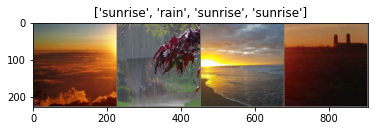

In [32]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                is_train = True
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                is_train = False

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase=='train':
              train_losses.append(epoch_loss)
              train_accs.append(epoch_acc)
              
            elif phase=='val':
              val_losses.append(epoch_loss)
              val_accs.append(epoch_acc)
          
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accs, val_losses, val_accs

In [0]:
def losses_accs_visualize(num_epochs, train_losses, train_accs, val_losses, val_accs):
  fig, ax = plt.subplots(figsize=(20, 10))
  x = np.arange(num_epochs)
  y0 = train_losses
  y1 = train_accs
  y2 = val_losses
  y3 = val_accs
  
  plt.subplot(321)
  plt.plot(x, y0)
  plt.title('train_losses')
  plt.grid(True)
  
  plt.subplot(322)
  plt.plot(x, y1)
  plt.title('train_accs')
  plt.grid(True)
  
  plt.subplot(323)
  plt.plot(x, y2)
  plt.title('val_losses')
  plt.grid(True)
  
  plt.subplot(324)
  plt.plot(x, y3)
  plt.title('val_accs')
  plt.grid(True)
  
  plt.show()
 

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
#Train model
model = models.resnet152(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

In [37]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1024)
model.activ = torch.nn.ReLU()
model.bn = torch.nn.BatchNorm1d(1024)
model.dropout = nn.Dropout(0.5)
model.fc1 = torch.nn.Linear(1024, 512)
model.activ1 = torch.nn.ReLU()
model.dropout1 = nn.Dropout(0.1)
model.fc2 = torch.nn.Linear(512, 20)
model.activ2 = torch.nn.ReLU()
model.fc3 = torch.nn.Linear(20, 4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [39]:
model, train_losses, train_accs, val_losses, val_accs = train_model(
    model, 
    criterion, 
    optimizer, 
    exp_lr_scheduler,
    num_epochs=30,
    )

Epoch 0/29
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.0549 Acc: 0.6499
val Loss: 0.4755 Acc: 0.8020

Epoch 1/29
----------
train Loss: 0.5677 Acc: 0.7883
val Loss: 0.2928 Acc: 0.8713

Epoch 2/29
----------
train Loss: 0.5799 Acc: 0.7883
val Loss: 0.2796 Acc: 0.9208

Epoch 3/29
----------
train Loss: 0.5627 Acc: 0.7913
val Loss: 0.2513 Acc: 0.8911

Epoch 4/29
----------
train Loss: 0.4690 Acc: 0.8259
val Loss: 0.1368 Acc: 0.9604

Epoch 5/29
----------
train Loss: 0.5289 Acc: 0.8200
val Loss: 0.1661 Acc: 0.9505

Epoch 6/29
----------
train Loss: 0.4246 Acc: 0.8566
val Loss: 0.1325 Acc: 0.9505

Epoch 7/29
----------
train Loss: 0.3969 Acc: 0.8625
val Loss: 0.1258 Acc: 0.9604

Epoch 8/29
----------
train Loss: 0.3336 Acc: 0.8783
val Loss: 0.1145 Acc: 0.9703

Epoch 9/29
----------
train Loss: 0.3941 Acc: 0.8615
val Loss: 0.1587 Acc: 0.9604

Epoch 10/29
----------
train Loss: 0.4167 Acc: 0.8506
val Loss: 0.1629 Acc: 0.9505

Epoch 11/29
----------
train Loss: 0.3666 Acc: 0.8744
val Loss: 0.1552 Acc: 0.9406

Epoch 12/29
----------
t

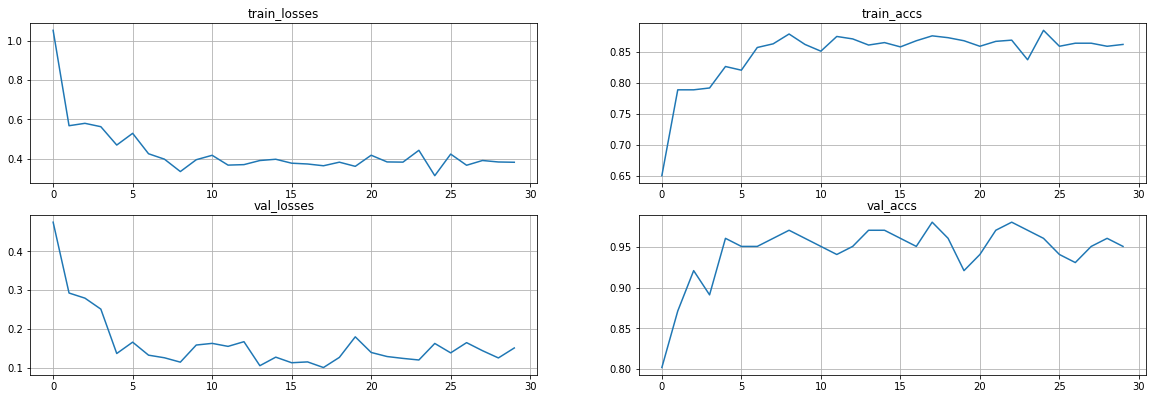

In [40]:
losses_accs_visualize(30, train_losses, train_accs, val_losses, val_accs)

In [41]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [0]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, data_transforms['val'])

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [45]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 13
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [0]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

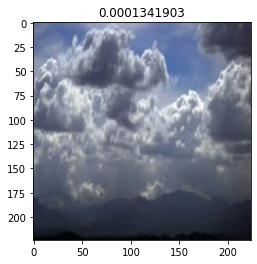

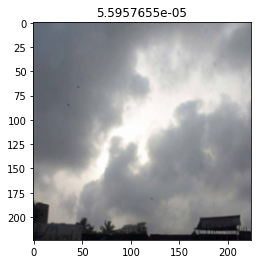

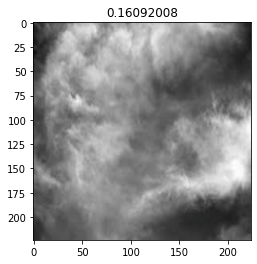

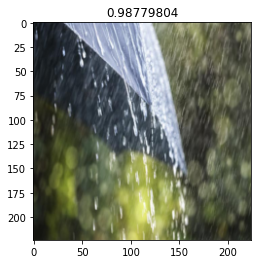

In [47]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    imshow(img, title=pred)